# Infer shape
To test the approach, I pass data from one of the three objects trained. First, I try to retrieve the latent vector, and then I try to reconstruct the object.

In [45]:
import numpy as np
import torch
import results
import os
from utils import utils
import plotly.graph_objects as go
import meshplot as mp
import model.sdf_model as sdf_model
from tqdm import tqdm
from utils.utils import SDFLoss_multishape
import trimesh
import skimage
import mesh_to_sdf
import matplotlib.pyplot as plt

Extract pointclouds from one of the objects randomly.

In [46]:
# dictionaries
objs_dict = np.load(os.path.join(os.path.dirname(results.__file__), 'objs_dict.npy'), allow_pickle=True).item()
samples_dict = np.load(os.path.join(os.path.dirname(results.__file__), 'samples_dict.npy'), allow_pickle=True).item()

# list of objects
objs = list(samples_dict.keys())

# select random object
random_obj = objs[np.random.randint(0, len(objs))]

# mesh for random object
mesh = objs_dict[random_obj]

In [47]:
# sample point cloud on random object
num_samples = 5000
samples = utils.mesh_to_pointcloud(mesh['verts'], mesh['faces'], num_samples)

fig = go.Figure(
    [go.Scatter3d(x=samples[:, 0], y=samples[:, 1],z=samples[:, 2], mode='markers',
        marker=dict(
            size=1
            )
    )]
)
fig.show()

Load model:

In [135]:
folder = '15_11_182625'
model = sdf_model.SDFModelMulti(hidden_layers=3)

# Load weights
weights_path = os.path.join(os.path.dirname(results.__file__), 'runs', folder, 'weights.pt')
model.load_state_dict(torch.
                      load(weights_path, map_location=torch.device('cpu')))

<All keys matched successfully>

Latent vector learnt during training:

In [ ]:
results_dict_path = os.path.join(os.path.dirname(results.__file__), 'runs', folder, 'results.npy')
results_dict = np.load(results_dict_path, allow_pickle=True).item()
latent_1 = torch.from_numpy(results_dict['train']['latent_codes'][-1][0])
latent_2 = torch.from_numpy(results_dict['train']['latent_codes'][-1][1])
latent_3 = torch.from_numpy(results_dict['train']['latent_codes'][-1][2])

model.eval()
latent_code.requires_grad = False
grid_values = torch.arange(-1, 1, 0.025) #0.015
grad_size_axis = grid_values.shape[0]
grid = torch.meshgrid(grid_values, grid_values, grid_values)
coords = torch.vstack((grid[0].ravel(), grid[1].ravel(), grid[2].ravel())).transpose(1, 0)

# Latent 1
latent_tile = torch.tile(latent_1, (coords.shape[0], 1))
coords_latent = torch.hstack((latent_tile, coords))
with torch.no_grad():
    sdf_1 = model(coords_latent)
    
# Latent 2
latent_tile = torch.tile(latent_2, (coords.shape[0], 1))
coords_latent = torch.hstack((latent_tile, coords))
with torch.no_grad():
    sdf_2 = model(coords_latent)
    
# Latent 3
latent_tile = torch.tile(latent_3, (coords.shape[0], 1))
coords_latent = torch.hstack((latent_tile, coords))
with torch.no_grad():
    sdf_3 = model(coords_latent)

In [158]:
def extract_mesh(grad_size_axis, sdf):
    grid_sdf = sdf.view(grad_size_axis, grad_size_axis, grad_size_axis).detach().numpy()
    vertices, faces, normals, _ = skimage.measure.marching_cubes(grid_sdf, level=-0.01)
    return vertices, faces

vertices, faces = extract_mesh(grad_size_axis, sdf_1)
shading={'wireframe':True, "colormap": "viridis"}
mp.plot(vertices, faces, c=vertices[:, 2])

vertices, faces = extract_mesh(grad_size_axis, sdf_2)
shading={'wireframe':True, "colormap": "viridis"}
mp.plot(vertices, faces, c=vertices[:, 2])

vertices, faces = extract_mesh(grad_size_axis, sdf_3)
shading={'wireframe':True, "colormap": "viridis"}
mp.plot(vertices, faces, c=vertices[:, 2])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(39.988657…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(39.5, 39.…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(40.498881…

Infer latent vector:

In [159]:
folder = '15_11_182625'
model = sdf_model.SDFModelMulti(hidden_layers=3)

# Load weights
weights_path = os.path.join(os.path.dirname(results.__file__), 'runs', folder, 'weights.pt')
model.load_state_dict(torch.
                      load(weights_path, map_location=torch.device('cpu')))

# initialise latent code and optimiser
latent_size = 128
latent_code = torch.normal(0, 1, size = (1, latent_size), dtype=torch.float32, requires_grad=True)
optim = torch.optim.Adam([latent_code], lr=0.001)

# initialise training parameters
epochs = 2000
sigma_regulariser = 0.0
lr_multiplier = 0.1
patience = 20
scheduler_latent = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
                                                            factor=lr_multiplier, 
                                                            patience=patience, 
                                                            threshold=0.005, threshold_mode='abs')
loss_values = []


# create dataset
samples_torch = torch.from_numpy(samples)
y = torch.full(size=(samples.shape[0], 1), fill_value=0)

# prediction
for epoch in tqdm(range(0, epochs)):
    latent_code_tile = torch.tile(latent_code, (samples.shape[0], 1))
    x = torch.hstack((latent_code_tile, samples_torch))
    optim.zero_grad()
    predictions = model(x)
    loss_value = SDFLoss_multishape(y, predictions, x[:, :latent_size], sigma=sigma_regulariser)
    loss_value.backward()
    optim.step()
    scheduler_latent.step(loss_value.item())
    loss_values.append(loss_value.detach().item())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:07<00:00,  8.08it/s]


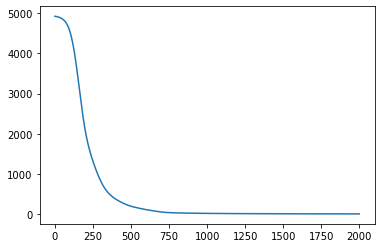

Final loss: 4.064060688018799


In [160]:
plt.plot(loss_values)
plt.show()
print(f'Final loss: {loss_values[-1]}')

Predict shape:

In [161]:
model.eval()
latent_code.requires_grad = False
grid_values = torch.arange(-1, 1, 0.025) #0.015
grad_size_axis = grid_values.shape[0]
grid = torch.meshgrid(grid_values, grid_values, grid_values)
coords = torch.vstack((grid[0].ravel(), grid[1].ravel(), grid[2].ravel())).transpose(1, 0)
latent_tile = torch.tile(latent_code, (coords.shape[0], 1))
coords_latent = torch.hstack((latent_tile, coords))
with torch.no_grad():
    sdf = model(coords_latent)

Render shape using marching cubes:

In [162]:
print(f'Max sdf: {torch.amax(sdf)}')
print(f'Min sdf: {torch.amin(sdf)}')

Max sdf: -0.005624998826533556
Min sdf: -0.33180758357048035


In [168]:
def extract_mesh(grad_size_axis, sdf):
    grid_sdf = sdf.view(grad_size_axis, grad_size_axis, grad_size_axis).detach().numpy()
    vertices, faces, normals, _ = skimage.measure.marching_cubes(grid_sdf, level=-0.01)
    return vertices, faces

vertices, faces = extract_mesh(grad_size_axis, sdf)
shading={'wireframe':True, "colormap": "viridis"}
mp.plot(vertices, faces)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(38.053050…

In [173]:
print((latent_code - latent_1).mean())
print((latent_code - latent_2).mean())
print((latent_code - latent_3).mean())

tensor(-0.1269)
tensor(-0.0940)
tensor(-0.1352)


In [ ]:
latent